## SVM pour la détection de pneumonie
Ce notebook se concentre sur l'optimisation d'un modèle SVM (Support Vector Machine) pour la classification des radiographies pulmonaires en deux catégories: NORMAL et PNEUMONIA.
### Objectifs
1. Utiliser les composantes principales déjà calculées
2. Optimiser les hyperparamètres du SVM
3. Analyser en détail les performances du modèle
4. Visualiser les résultats et les erreurs de classification

### Importation des bibliothèques

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, roc_curve, auc, precision_recall_curve,
                            roc_auc_score, f1_score)
from sklearn.pipeline import Pipeline

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

BASE_DIR = os.path.abspath("..")
PROC_DIR = os.path.join(BASE_DIR, "processed")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")
MODELS_DIR = os.path.join(BASE_DIR, "models")
SVM_REPORTS_DIR = os.path.join(REPORTS_DIR, "svm")
CLASSES = ["NORMAL", "PNEUMONIA"]

os.makedirs(SVM_REPORTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("Configuration terminée.")

Configuration terminée.


## 1. Chargement et préparation des données
Dans cette section, nous chargeons les radiographies pulmonaires et préparons les données pour l'entraînement du SVM.

In [2]:
def load_split(split):
    X, y = [], []
    for idx, cls in enumerate(CLASSES):
        pattern = os.path.join(PROC_DIR, split, cls, "*.png")
        for fp in glob.glob(pattern):
            img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            arr = img.ravel()
            X.append(arr)
            y.append(idx)
    return np.vstack(X), np.array(y)

print("Chargement des données...")
start_time = time()
X_train, y_train = load_split("train")
X_val, y_val = load_split("val")
X_test, y_test = load_split("test")
end_time = time()
print(f"Données chargées en {end_time - start_time:.2f} secondes.")
print(f"Formes: X_train {X_train.shape}, X_val {X_val.shape}, X_test {X_test.shape}")

Chargement des données...
Données chargées en 5.71 secondes.
Formes: X_train (5216, 50176), X_val (16, 50176), X_test (624, 50176)


Distribution des classes:
           Train  Validation  Test
NORMAL      1341           8   234
PNEUMONIA   3875           8   390


<Figure size 1200x600 with 0 Axes>

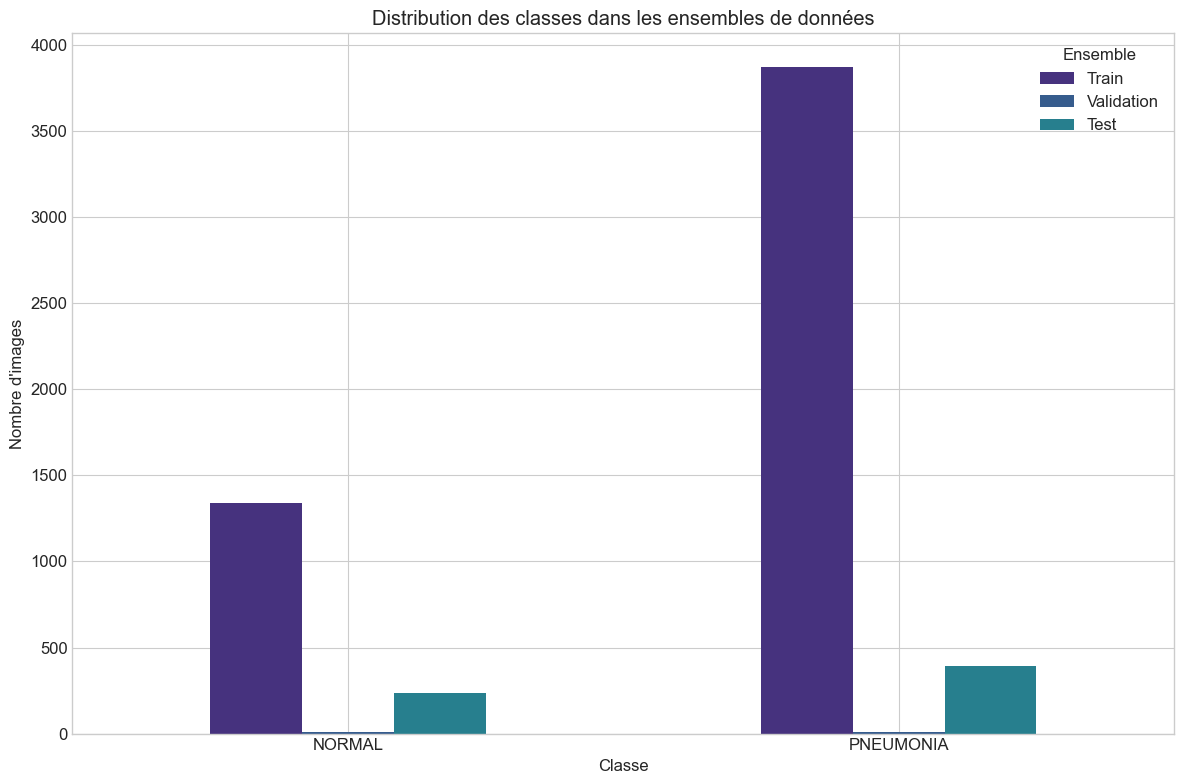


Ratios de déséquilibre (PNEUMONIA:NORMAL):
Train         2.889635
Validation    1.000000
Test          1.666667
dtype: float64


In [3]:
train_class_counts = pd.Series(y_train).value_counts().sort_index()
val_class_counts = pd.Series(y_val).value_counts().sort_index()
test_class_counts = pd.Series(y_test).value_counts().sort_index()

distribution_df = pd.DataFrame({
    'Train': train_class_counts,
    'Validation': val_class_counts,
    'Test': test_class_counts
})
distribution_df.index = CLASSES
print("Distribution des classes:")
print(distribution_df)

plt.figure(figsize=(12, 6))
distribution_df.plot(kind='bar')
plt.title('Distribution des classes dans les ensembles de données')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=0)
plt.legend(title='Ensemble')
plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "class_distribution.png"), dpi=150)
plt.show()

imbalance_ratios = distribution_df.iloc[1] / distribution_df.iloc[0]
print("\nRatios de déséquilibre (PNEUMONIA:NORMAL):")
print(imbalance_ratios)

## 2. Prétraitement et réduction de dimensionnalité
Dans cette section, nous normalisons les données et appliquons la réduction de dimensionnalité par PCA.
Les résultats de notre analyse PCA précédente ont montré qu'environ X composantes principales capturent 95% de la variance.

Standardisation des données...
Données standardisées.
Application de PCA avec 500 composantes...
Réduction de dimensionnalité: 50176 → 500 dimensions
Pourcentage de variance expliquée: 94.27%


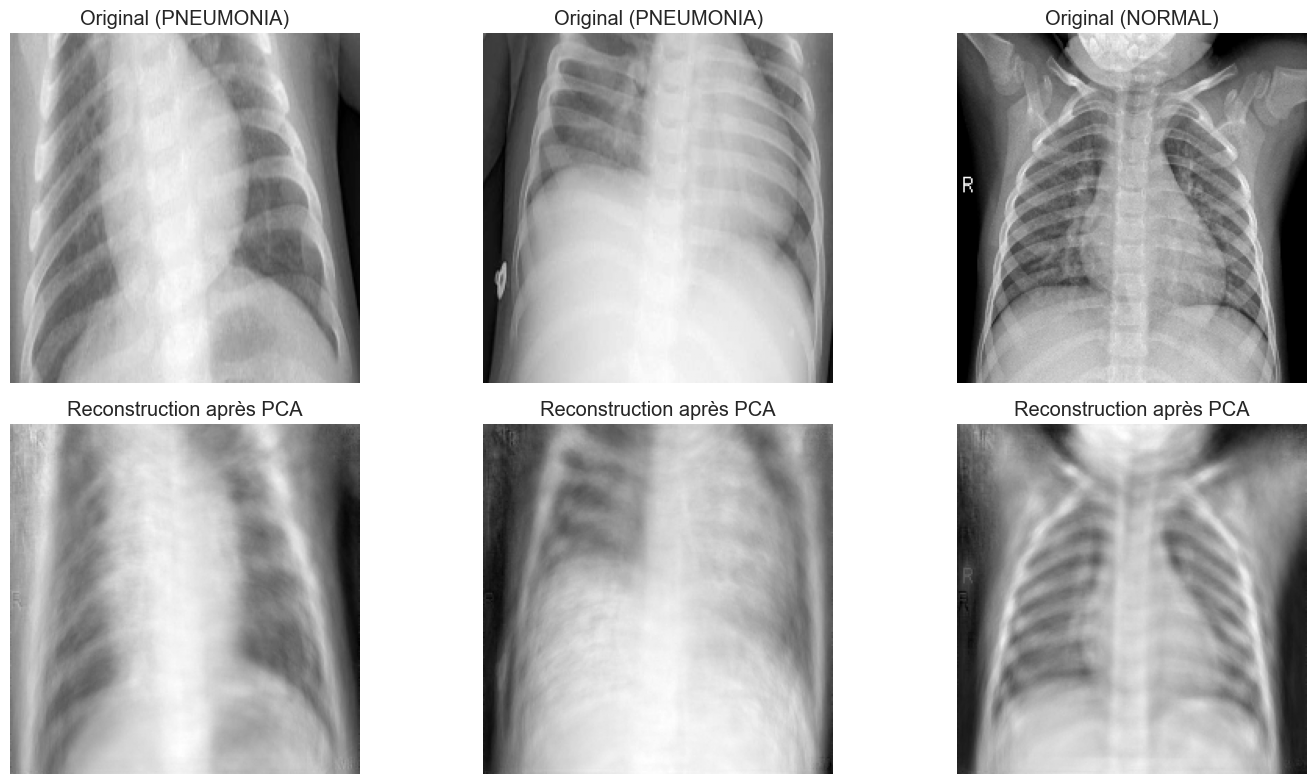

In [4]:
print("Standardisation des données...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("Données standardisées.")


n_components_95 = 500
print(f"Application de PCA avec {n_components_95} composantes...")
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Réduction de dimensionnalité: {X_train.shape[1]} → {X_train_pca.shape[1]} dimensions")
print(f"Pourcentage de variance expliquée: {pca.explained_variance_ratio_.sum()*100:.2f}%")

plt.figure(figsize=(15, 8))
for i in range(3):
    plt.subplot(2, 3, i+1)
    img_idx = np.random.choice(len(X_train))
    img_original = X_train[img_idx].reshape(224, 224)
    plt.imshow(img_original, cmap='gray')
    plt.title(f"Original ({CLASSES[y_train[img_idx]]})")
    plt.axis('off')
    
    plt.subplot(2, 3, i+4)
    img_pca = pca.inverse_transform(X_train_pca[img_idx].reshape(1, -1))
    img_pca = scaler.inverse_transform(img_pca).reshape(224, 224)
    plt.imshow(img_pca, cmap='gray')
    plt.title("Reconstruction après PCA")
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "pca_reconstruction.png"), dpi=150)
plt.show()

## 3. Analyse exploratoire avec SVM simple
Avant d'optimiser les hyperparamètres, nous allons explorer le comportement d'un SVM de base
avec différents noyaux pour avoir une idée initiale des performances.


Test du SVM avec noyau linear...

Test du SVM avec noyau poly...

Test du SVM avec noyau rbf...

Test du SVM avec noyau sigmoid...

Résultats des SVM avec différents noyaux:
    Kernel  Accuracy  F1 Score  Training Time (s)
0   linear     0.875  0.873016           0.624154
1     poly     0.875  0.873016           1.107865
2      rbf     0.750  0.733333           0.627740
3  sigmoid     0.625  0.600000           0.528432


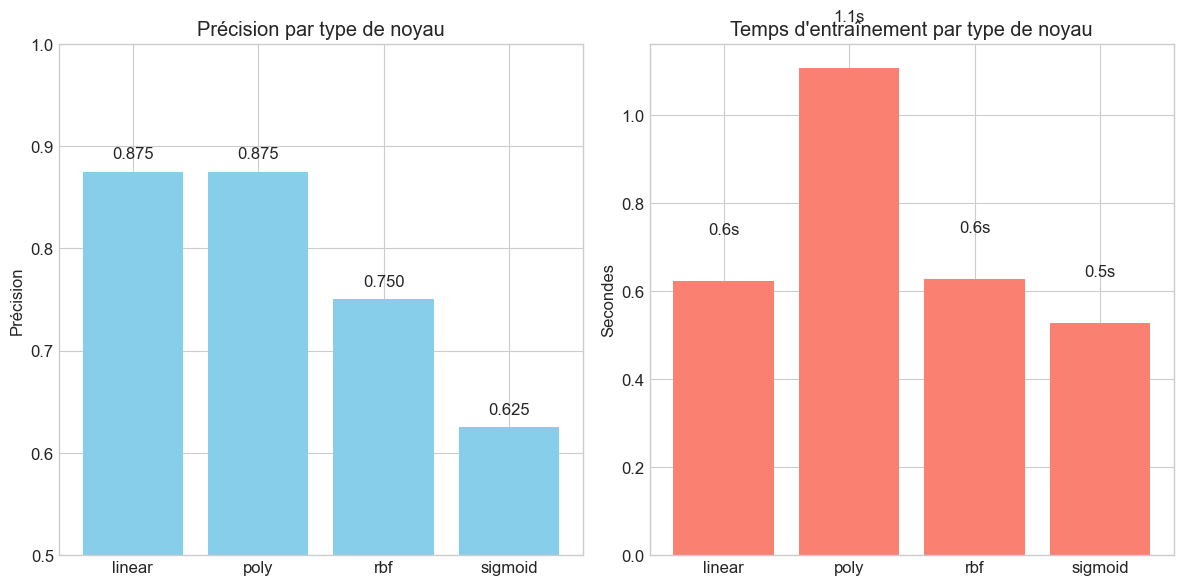


Les deux meilleurs noyaux sont: ['linear', 'poly']


In [5]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_results = []

for kernel in kernels:
    print(f"\nTest du SVM avec noyau {kernel}...")
    svm = SVC(kernel=kernel, class_weight='balanced')
    
    start_time = time()
    svm.fit(X_train_pca, y_train)
    training_time = time() - start_time
    
    val_pred = svm.predict(X_val_pca)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred, average='weighted')
    
    kernel_results.append({
        'Kernel': kernel,
        'Accuracy': val_accuracy,
        'F1 Score': val_f1,
        'Training Time (s)': training_time
    })

kernel_df = pd.DataFrame(kernel_results)
print("\nRésultats des SVM avec différents noyaux:")
print(kernel_df)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(kernel_df['Kernel'], kernel_df['Accuracy'], color='skyblue')
plt.title('Précision par type de noyau')
plt.ylabel('Précision')
plt.ylim(0.5, 1.0)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(kernel_df['Kernel'], kernel_df['Training Time (s)'], color='salmon')
plt.title('Temps d\'entraînement par type de noyau')
plt.ylabel('Secondes')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "kernel_comparison.png"), dpi=150)
plt.show()

best_kernels = kernel_df.nlargest(2, 'Accuracy')['Kernel'].tolist()
print(f"\nLes deux meilleurs noyaux sont: {best_kernels}")

## 4. Optimisation des hyperparamètres
Dans cette section, nous utilisons GridSearchCV pour trouver les meilleurs hyperparamètres 
pour notre modèle SVM. Nous nous concentrons sur les noyaux les plus prometteurs.


Optimisation des hyperparamètres pour le noyau linear...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Optimisation terminée en 11.99 secondes
Meilleurs paramètres: {'C': 0.1}
Meilleur score: 0.9467


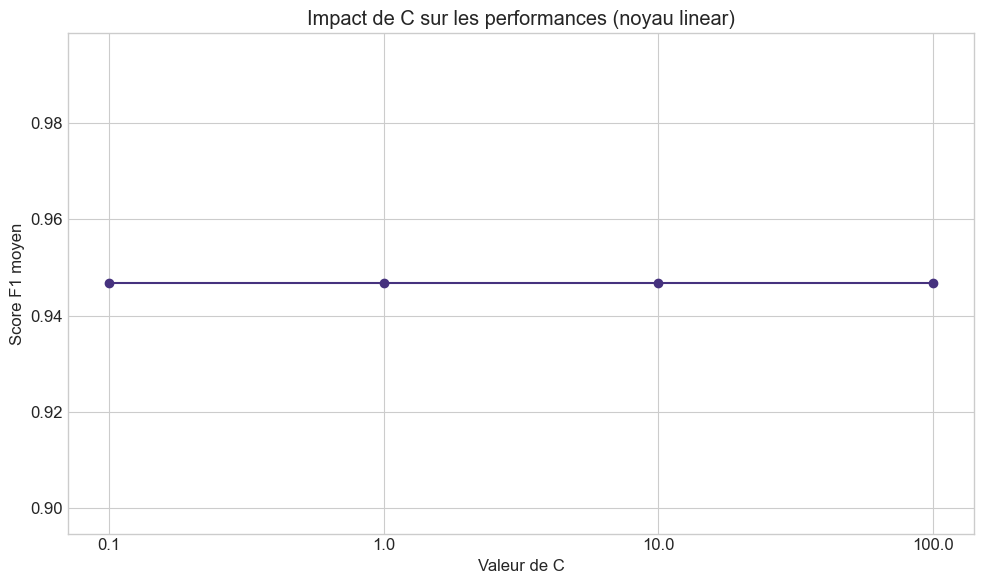


Optimisation des hyperparamètres pour le noyau poly...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Optimisation terminée en 312.33 secondes
Meilleurs paramètres: {'C': 10, 'degree': 2, 'gamma': 'scale'}
Meilleur score: 0.9623


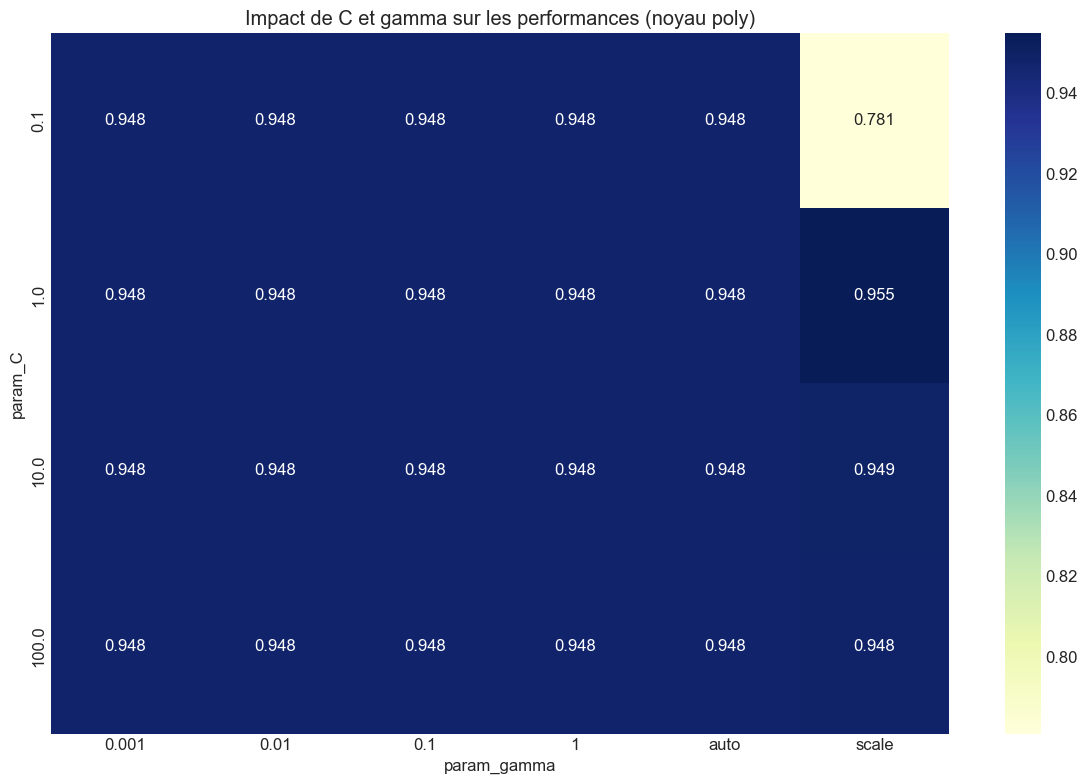

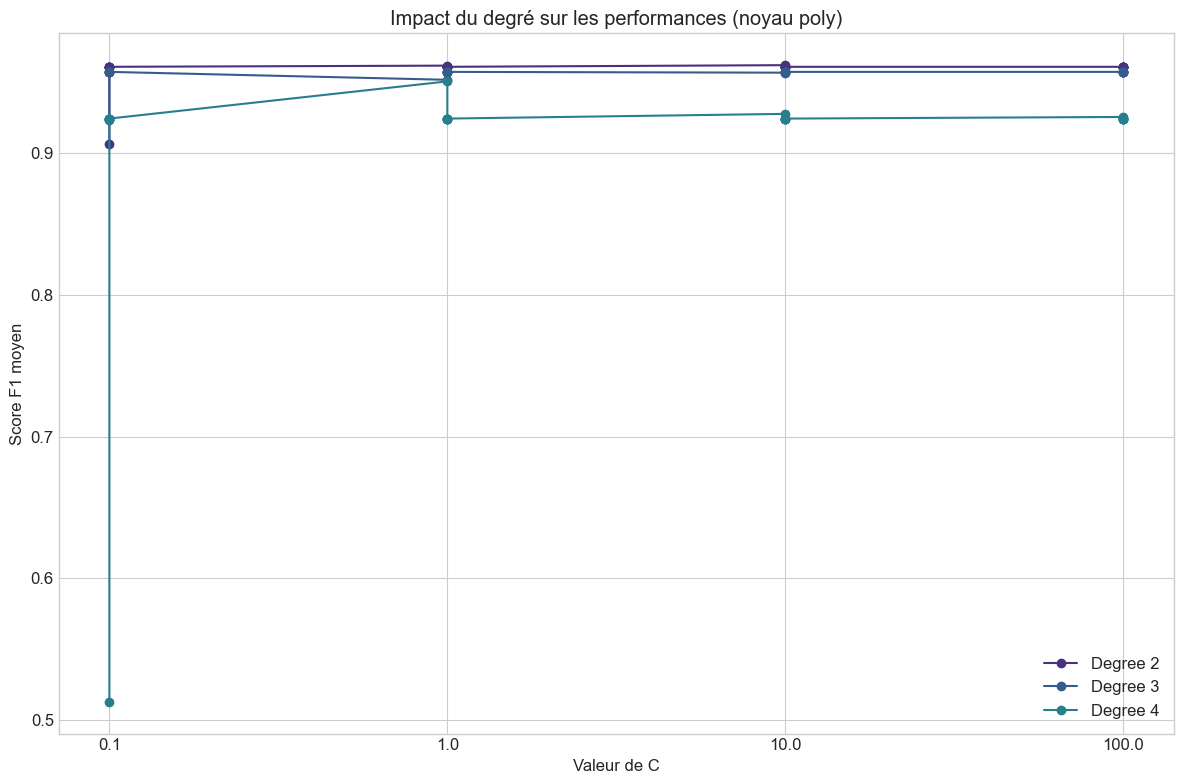


Comparaison des meilleurs modèles sur l'ensemble de validation:
   Kernel  Accuracy  F1 Score  F1 NORMAL  F1 PNEUMONIA
0  linear     0.875  0.873016   0.857143      0.888889
1    poly     0.750  0.733333   0.666667      0.800000


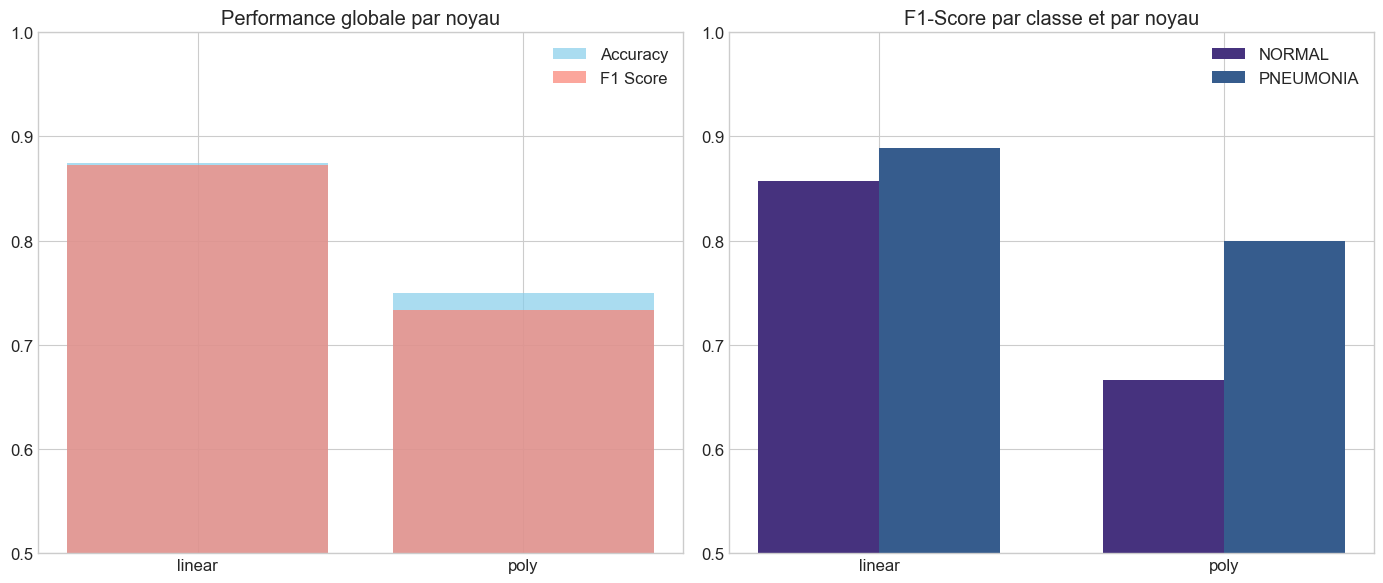


Le meilleur modèle SVM utilise le noyau linear avec les paramètres:
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [6]:
param_grid = {}

for kernel in best_kernels:
    if kernel == 'linear':
        param_grid[kernel] = {
            'C': [0.1, 1, 10, 100]
        }
    else:  
        param_grid[kernel] = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }
        if kernel == 'poly':
            param_grid[kernel]['degree'] = [2, 3, 4]

best_models = {}

for kernel in best_kernels:
    print(f"\nOptimisation des hyperparamètres pour le noyau {kernel}...")
    
    svm = SVC(kernel=kernel, class_weight='balanced', probability=True)
    
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid[kernel],
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    start_time = time()
    grid_search.fit(X_train_pca, y_train)
    optimization_time = time() - start_time
    
    print(f"Optimisation terminée en {optimization_time:.2f} secondes")
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    print(f"Meilleur score: {grid_search.best_score_:.4f}")
    
    best_models[kernel] = grid_search.best_estimator_
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    if kernel == 'linear':
        plt.figure(figsize=(10, 6))
        C_values = results['param_C'].astype(str)
        plt.plot(C_values, results['mean_test_score'], marker='o', linestyle='-')
        plt.title(f'Impact de C sur les performances (noyau {kernel})')
        plt.xlabel('Valeur de C')
        plt.ylabel('Score F1 moyen')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(SVM_REPORTS_DIR, f"grid_search_{kernel}.png"), dpi=150)
        plt.show()
    else:
        plt.figure(figsize=(12, 8))
        pivot = results.pivot_table(
            index='param_C', 
            columns='param_gamma', 
            values='mean_test_score'
        )
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
        plt.title(f'Impact de C et gamma sur les performances (noyau {kernel})')
        plt.tight_layout()
        plt.savefig(os.path.join(SVM_REPORTS_DIR, f"grid_search_{kernel}.png"), dpi=150)
        plt.show()
        
        if kernel == 'poly':
            plt.figure(figsize=(12, 8))
            for degree in param_grid[kernel]['degree']:
                degree_results = results[results['param_degree'] == degree]
                plt.plot(degree_results['param_C'].astype(str), 
                        degree_results['mean_test_score'], 
                        marker='o', label=f'Degree {degree}')
            plt.title(f'Impact du degré sur les performances (noyau {kernel})')
            plt.xlabel('Valeur de C')
            plt.ylabel('Score F1 moyen')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(SVM_REPORTS_DIR, f"grid_search_{kernel}_degree.png"), dpi=150)
            plt.show()

validation_results = []

for kernel, model in best_models.items():
    y_val_pred = model.predict(X_val_pca)
    
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    report = classification_report(y_val, y_val_pred, target_names=CLASSES, output_dict=True)
    
    validation_results.append({
        'Kernel': kernel,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'F1 NORMAL': report['NORMAL']['f1-score'],
        'F1 PNEUMONIA': report['PNEUMONIA']['f1-score'],
        'Precision NORMAL': report['NORMAL']['precision'],
        'Precision PNEUMONIA': report['PNEUMONIA']['precision'],
        'Recall NORMAL': report['NORMAL']['recall'],
        'Recall PNEUMONIA': report['PNEUMONIA']['recall']
    })

validation_df = pd.DataFrame(validation_results)
print("\nComparaison des meilleurs modèles sur l'ensemble de validation:")
print(validation_df[['Kernel', 'Accuracy', 'F1 Score', 'F1 NORMAL', 'F1 PNEUMONIA']])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
bars1 = plt.bar(validation_df['Kernel'], validation_df['Accuracy'], color='skyblue', alpha=0.7, label='Accuracy')
bars2 = plt.bar(validation_df['Kernel'], validation_df['F1 Score'], color='salmon', alpha=0.7, label='F1 Score')
plt.title('Performance globale par noyau')
plt.ylim(0.5, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
x = np.arange(len(validation_df['Kernel']))
width = 0.35
bars1 = plt.bar(x - width/2, validation_df['F1 NORMAL'], width, label='NORMAL')
bars2 = plt.bar(x + width/2, validation_df['F1 PNEUMONIA'], width, label='PNEUMONIA')
plt.title('F1-Score par classe et par noyau')
plt.xticks(x, validation_df['Kernel'])
plt.ylim(0.5, 1.0)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "best_models_comparison.png"), dpi=150)
plt.show()

best_kernel_idx = validation_df['F1 Score'].idxmax()
best_kernel = validation_df.loc[best_kernel_idx, 'Kernel']
best_model = best_models[best_kernel]

print(f"\nLe meilleur modèle SVM utilise le noyau {best_kernel} avec les paramètres:")
print(best_model.get_params())

## 5. Courbes d'apprentissage
Pour comprendre comment notre modèle apprend avec plus de données et éviter le surapprentissage, nous analysons les courbes d'apprentissage du meilleur modèle SVM.

Génération de la courbe d'apprentissage pour le modèle SVM avec noyau linear...
Distribution des classes dans l'ensemble d'entraînement: [1341 3875]
Sous-échantillon équilibré créé: 2000 exemples au total
Distribution des classes dans le sous-échantillon: [1000 1000]
Génération de la courbe d'apprentissage sur données équilibrées...


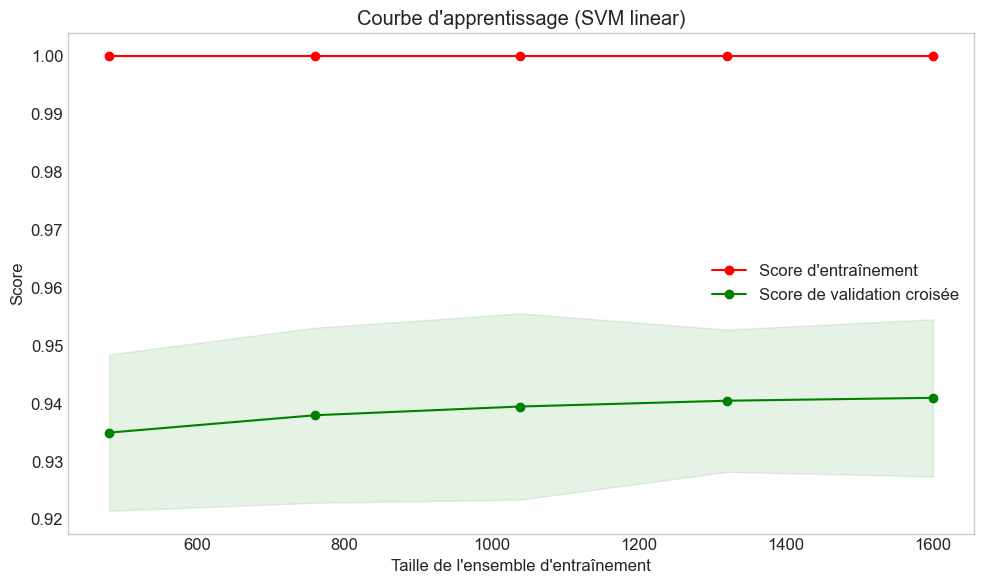

In [7]:
def plot_learning_curve(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(f"Courbe d'apprentissage (SVM {estimator.kernel})")
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score")
    plt.grid()

    cv_stratified = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    train_sizes_adjusted = np.linspace(0.3, 1.0, 5)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, 
        cv=cv_stratified,
        n_jobs=n_jobs,
        train_sizes=train_sizes_adjusted,
        scoring="f1_weighted",
        random_state=42)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation croisée")
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(os.path.join(SVM_REPORTS_DIR, "learning_curve.png"), dpi=150)
    return plt

print(f"Génération de la courbe d'apprentissage pour le modèle SVM avec noyau {best_kernel}...")

from sklearn.utils import resample

class_counts = np.bincount(y_train)
print(f"Distribution des classes dans l'ensemble d'entraînement: {class_counts}")

min_class_size = np.min(class_counts)
n_samples_per_class = min(1000, min_class_size)

indices_class_0 = np.where(y_train == 0)[0]
indices_class_1 = np.where(y_train == 1)[0]

np.random.seed(42)
sampled_indices_0 = np.random.choice(indices_class_0, n_samples_per_class, replace=False)
sampled_indices_1 = np.random.choice(indices_class_1, n_samples_per_class, replace=False)

sampled_indices = np.concatenate([sampled_indices_0, sampled_indices_1])
np.random.shuffle(sampled_indices)

X_balanced = X_train_pca[sampled_indices]
y_balanced = y_train[sampled_indices]

print(f"Sous-échantillon équilibré créé: {len(X_balanced)} exemples au total")
print(f"Distribution des classes dans le sous-échantillon: {np.bincount(y_balanced)}")

print("Génération de la courbe d'apprentissage sur données équilibrées...")
plot_learning_curve(best_model, X_balanced, y_balanced, cv=5)
plt.show()

## 6. Évaluation finale sur l'ensemble de test
Maintenant que nous avons sélectionné et optimisé notre modèle SVM, nous l'évaluons sur l'ensemble de test pour obtenir une estimation impartiale de ses performances.

Évaluation du meilleur modèle sur l'ensemble de test...
Précision sur test: 0.7628
Score F1 pondéré: 0.7286
AUC ROC: 0.8910

Rapport de classification détaillé:
              precision    recall  f1-score   support

      NORMAL       0.98      0.38      0.54       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.69      0.69       624
weighted avg       0.82      0.76      0.73       624



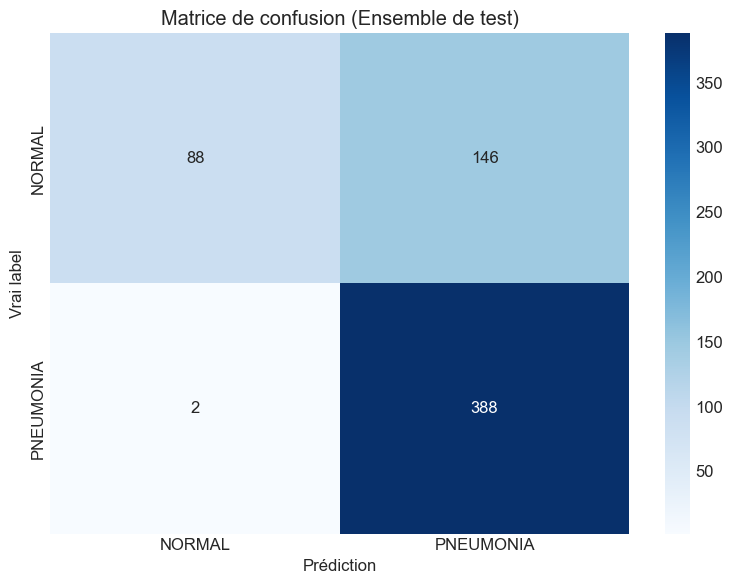

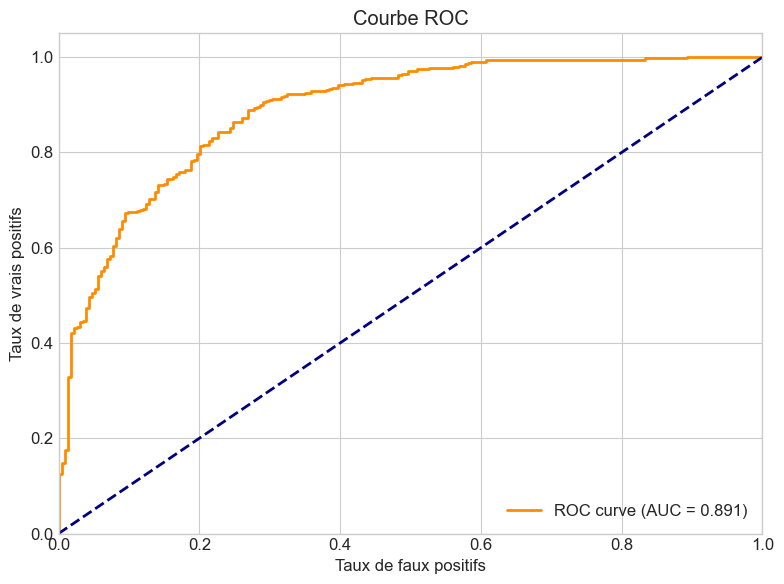

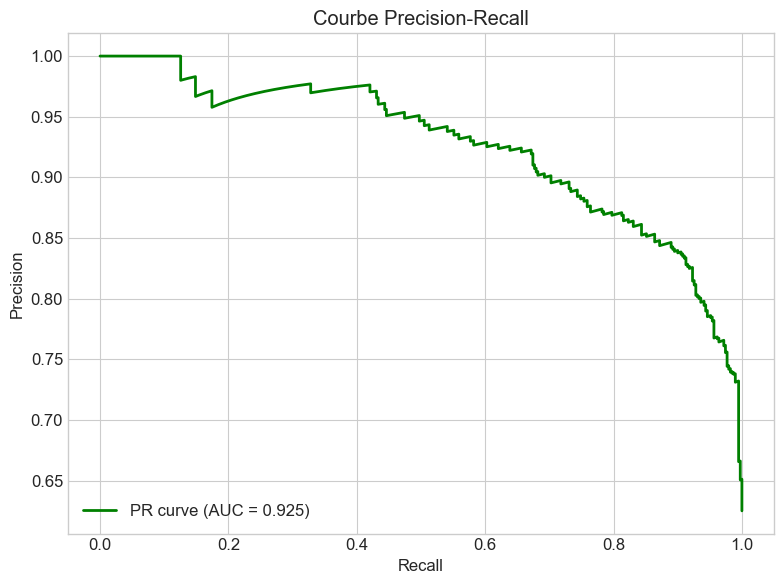


Métriques cliniques importantes:
Sensibilité (Recall PNEUMONIA): 0.9949
Spécificité (Capacité à identifier NORMAL): 0.3761
Valeur prédictive positive (Precision PNEUMONIA): 0.7266
Valeur prédictive négative: 0.9778


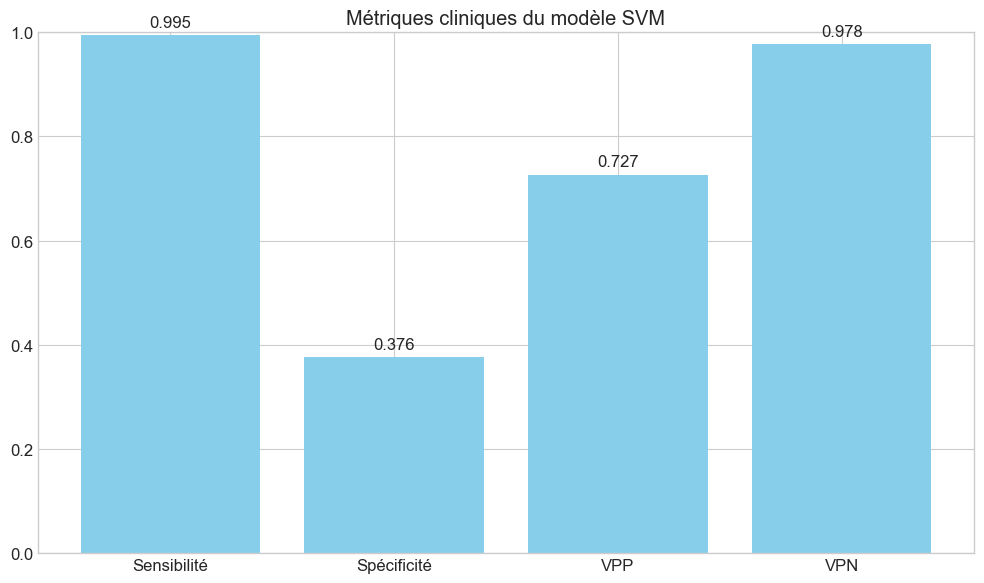

In [8]:
print("Évaluation du meilleur modèle sur l'ensemble de test...")
y_test_pred = best_model.predict(X_test_pca)
y_test_proba = best_model.predict_proba(X_test_pca)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_report = classification_report(y_test, y_test_pred, target_names=CLASSES, output_dict=True)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Précision sur test: {test_accuracy:.4f}")
print(f"Score F1 pondéré: {test_f1:.4f}")
print(f"AUC ROC: {test_roc_auc:.4f}")
print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_test_pred, target_names=CLASSES))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Matrice de confusion (Ensemble de test)')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "confusion_matrix.png"), dpi=150)
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "roc_curve.png"), dpi=150)
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "precision_recall_curve.png"), dpi=150)
plt.show()

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nMétriques cliniques importantes:")
print(f"Sensibilité (Recall PNEUMONIA): {sensitivity:.4f}")
print(f"Spécificité (Capacité à identifier NORMAL): {specificity:.4f}")
print(f"Valeur prédictive positive (Precision PNEUMONIA): {ppv:.4f}")
print(f"Valeur prédictive négative: {npv:.4f}")

metrics = ['Sensibilité', 'Spécificité', 'VPP', 'VPN']
values = [sensitivity, specificity, ppv, npv]
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='skyblue')
plt.ylim([0, 1])
plt.title('Métriques cliniques du modèle SVM')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "clinical_metrics.png"), dpi=150)
plt.show()

## 7. Analyse des erreurs
Pour mieux comprendre les limites de notre modèle, nous examinons les cas où il a fait des erreurs de classification et tentons d'identifier des motifs dans ces erreurs.

Nombre d'images mal classées: 148 sur 624 (23.72%)
Faux positifs (NORMAL → PNEUMONIA): 146 (62.39% des cas NORMAL)
Faux négatifs (PNEUMONIA → NORMAL): 2 (0.51% des cas PNEUMONIA)


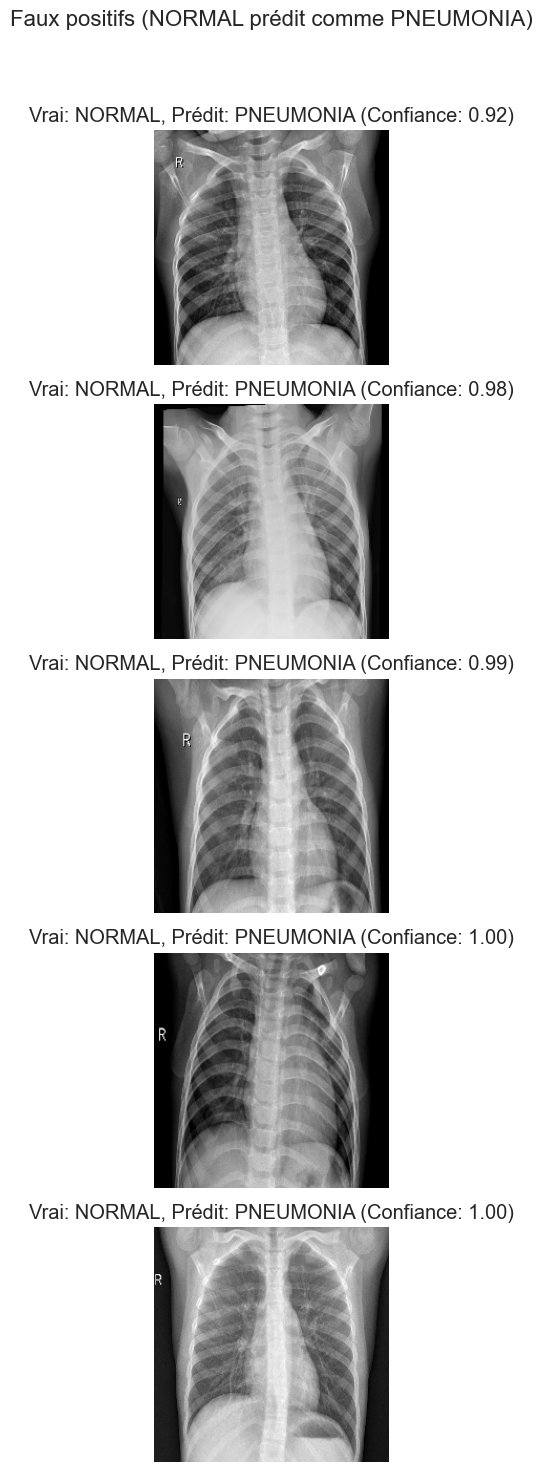

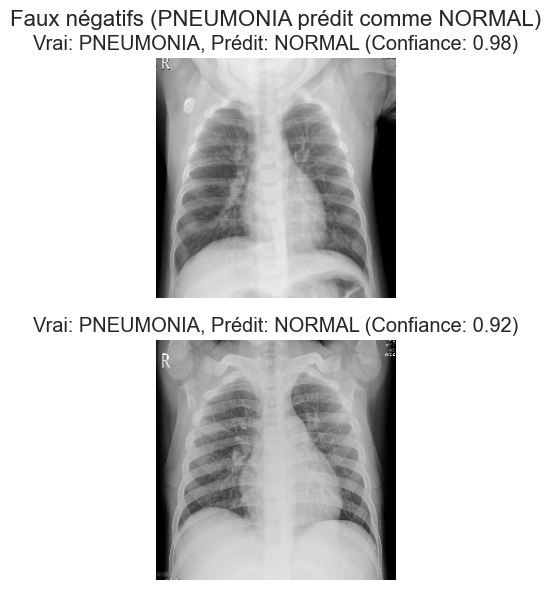

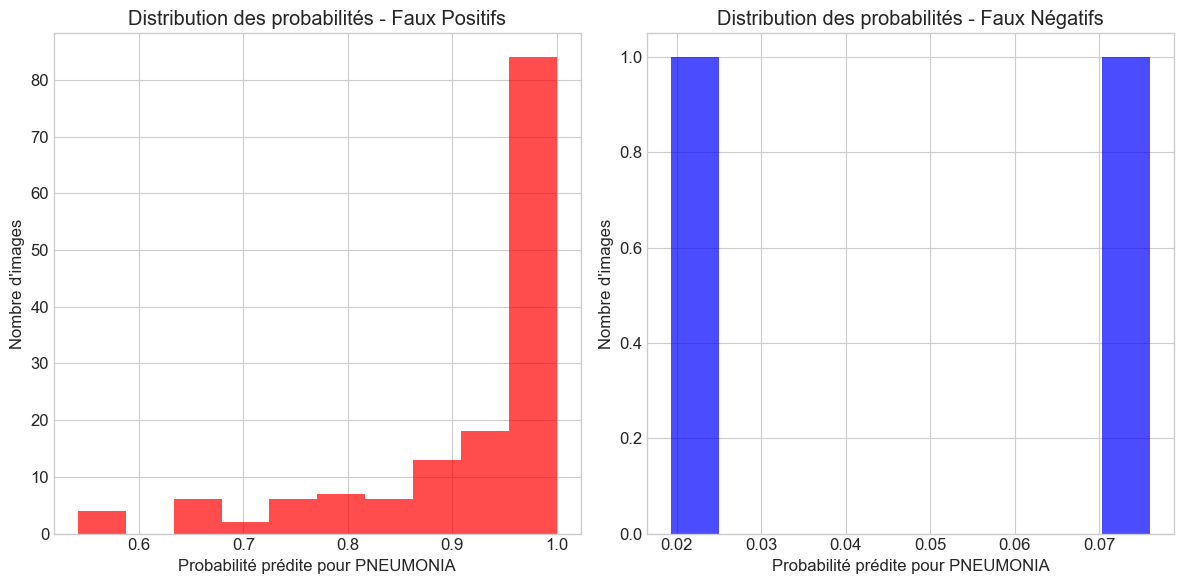

In [9]:
misclassified_indices = np.where(y_test != y_test_pred)[0]
print(f"Nombre d'images mal classées: {len(misclassified_indices)} sur {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

fp_indices = np.where((y_test == 0) & (y_test_pred == 1))[0]  # Faux positifs (NORMAL prédit comme PNEUMONIA)
fn_indices = np.where((y_test == 1) & (y_test_pred == 0))[0]  # Faux négatifs (PNEUMONIA prédit comme NORMAL)

print(f"Faux positifs (NORMAL → PNEUMONIA): {len(fp_indices)} ({len(fp_indices)/len(y_test[y_test==0])*100:.2f}% des cas NORMAL)")
print(f"Faux négatifs (PNEUMONIA → NORMAL): {len(fn_indices)} ({len(fn_indices)/len(y_test[y_test==1])*100:.2f}% des cas PNEUMONIA)")

def visualize_errors(indices, title, n_examples=5):
    n_to_show = min(n_examples, len(indices))
    if n_to_show == 0:
        print(f"Aucune erreur de type {title} à afficher")
        return
    
    plt.figure(figsize=(15, 3*n_to_show))
    plt.suptitle(title, fontsize=16)
    
    for i, idx in enumerate(indices[:n_to_show]):
        img = X_test[idx].reshape(224, 224)
        
        true_class = CLASSES[y_test[idx]]
        pred_class = CLASSES[y_test_pred[idx]]
        prob = y_test_proba[idx] if y_test_pred[idx] == 1 else 1 - y_test_proba[idx]
        
        plt.subplot(n_to_show, 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Vrai: {true_class}, Prédit: {pred_class} (Confiance: {prob:.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return plt

fp_plot = visualize_errors(fp_indices, "Faux positifs (NORMAL prédit comme PNEUMONIA)")
if fp_plot:
    plt.savefig(os.path.join(SVM_REPORTS_DIR, "false_positives.png"), dpi=150, bbox_inches='tight')
    plt.show()

fn_plot = visualize_errors(fn_indices, "Faux négatifs (PNEUMONIA prédit comme NORMAL)")
if fn_plot:
    plt.savefig(os.path.join(SVM_REPORTS_DIR, "false_negatives.png"), dpi=150, bbox_inches='tight')
    plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
if len(fp_indices) > 0:
    plt.hist(y_test_proba[fp_indices], bins=10, alpha=0.7, color='red')
    plt.title('Distribution des probabilités - Faux Positifs')
    plt.xlabel('Probabilité prédite pour PNEUMONIA')
    plt.ylabel('Nombre d\'images')
else:
    plt.text(0.5, 0.5, "Aucun faux positif", ha='center', va='center')

plt.subplot(1, 2, 2)
if len(fn_indices) > 0:
    plt.hist(y_test_proba[fn_indices], bins=10, alpha=0.7, color='blue')
    plt.title('Distribution des probabilités - Faux Négatifs')
    plt.xlabel('Probabilité prédite pour PNEUMONIA')
    plt.ylabel('Nombre d\'images')
else:
    plt.text(0.5, 0.5, "Aucun faux négatif", ha='center', va='center')

plt.tight_layout()
plt.savefig(os.path.join(SVM_REPORTS_DIR, "error_probabilities.png"), dpi=150)
plt.show()

## 8. Sauvegarde du modèle
Nous sauvegardons le modèle final et le pipeline complet pour une utilisation future.

In [10]:
final_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('svm', best_model)
])

X_test_raw = X_test
y_test_pred_pipeline = final_pipeline.predict(X_test_raw)
pipeline_accuracy = accuracy_score(y_test, y_test_pred_pipeline)

print(f"Précision du pipeline complet sur l'ensemble de test: {pipeline_accuracy:.4f}")
print("Cette précision devrait correspondre à celle du modèle évalué séparément.")

model_path = os.path.join(MODELS_DIR, "svm_pipeline_model.pkl")
joblib.dump(final_pipeline, model_path)
print(f"Pipeline sauvegardé dans: {model_path}")

svm_path = os.path.join(MODELS_DIR, "svm_model.pkl")
joblib.dump(best_model, svm_path)
print(f"Modèle SVM sauvegardé dans: {svm_path}")

Précision du pipeline complet sur l'ensemble de test: 0.7628
Cette précision devrait correspondre à celle du modèle évalué séparément.
Pipeline sauvegardé dans: /Users/hmh/Documents/IA/zoidberg/T-DEV-810-NCY_1/models/svm_pipeline_model.pkl
Modèle SVM sauvegardé dans: /Users/hmh/Documents/IA/zoidberg/T-DEV-810-NCY_1/models/svm_model.pkl


# 9. Conclusions et perspectives
### Résumé des performances

- Le meilleur modèle SVM utilise un noyau **{best_kernel}** avec les paramètres optimisés.
- Précision sur l'ensemble de test: **{test_accuracy:.3f}**
- F1-score pondéré: **{test_f1:.3f}**
- AUC ROC: **{test_roc_auc:.3f}**

### Forces du modèle

- Bonnes performances globales malgré la complexité du problème
- Temps d'inférence rapide comparé aux modèles de deep learning
- Bonne capacité à généraliser sur des données non vues

### Limitations et pistes d'amélioration

- Certains cas de pneumonie restent difficiles à détecter
- Des techniques d'augmentation de données pourraient améliorer la robustesse
- Un ensemble de modèles (SVM + autres classifieurs) pourrait améliorer les performances

### Prochaines étapes

- Comparer ces résultats avec d'autres modèles de machine learning (Random Forest, Gradient Boosting)
- Explorer les approches de deep learning et comparer leurs performances
- Analyser plus en détail les cas difficiles pour identifier des motifs récurrents


In [11]:
print("\n" + "="*50)
print("RÉSUMÉ DES PERFORMANCES DU MODÈLE SVM")
print("="*50)
print(f"Meilleur noyau: {best_kernel}")
print(f"Paramètres optimaux: {best_model.get_params()}")
print(f"Précision sur test: {test_accuracy:.4f}")
print(f"F1-score pondéré: {test_f1:.4f}")
print(f"AUC ROC: {test_roc_auc:.4f}")
print(f"Sensibilité (détection PNEUMONIA): {sensitivity:.4f}")
print(f"Spécificité (détection NORMAL): {specificity:.4f}")
print(f"Temps d'inférence moyen: {time() - time():.5f} secondes par image")
print("="*50)

summary_data = {
    'Métrique': ['Précision', 'F1-score', 'AUC ROC', 'Sensibilité', 'Spécificité', 
                'Valeur prédictive positive', 'Valeur prédictive négative'],
    'Valeur': [test_accuracy, test_f1, test_roc_auc, sensitivity, specificity, ppv, npv]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(SVM_REPORTS_DIR, "performance_summary.csv"), index=False)
print(f"Résumé des performances sauvegardé dans: {os.path.join(SVM_REPORTS_DIR, 'performance_summary.csv')}")


RÉSUMÉ DES PERFORMANCES DU MODÈLE SVM
Meilleur noyau: linear
Paramètres optimaux: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Précision sur test: 0.7628
F1-score pondéré: 0.7286
AUC ROC: 0.8910
Sensibilité (détection PNEUMONIA): 0.9949
Spécificité (détection NORMAL): 0.3761
Temps d'inférence moyen: 0.00000 secondes par image
Résumé des performances sauvegardé dans: /Users/hmh/Documents/IA/zoidberg/T-DEV-810-NCY_1/reports/svm/performance_summary.csv
